In [2]:
import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.style.use('ggplot')

In [75]:
df = pd.read_csv('data/clean_data_full.csv')

print(df.shape)
print(f"Total items: {len(df['product_name'].unique())}, Total Orders: {len(df['order_id'].unique())}")
df.head()

(1384617, 2)
Total items: 39123, Total Orders: 131209


,order_id,product_name
0,1,Bulgarian Yogurt
1,1,Organic 4% Milk Fat Whole Milk Cottage Cheese
2,1,Organic Celery Hearts
3,1,Cucumber Kirby
4,1,Lightly Smoked Sardines in Olive Oil


In [76]:
# filter out orders have only 1 item & buyers have 1 order
mask = df['order_id'].value_counts()
df = df[df['order_id'].isin(mask.index[mask > 1])]

mask = df.groupby('product_name')['order_id'].count()
df = df[df['product_name'].isin(mask.index[mask > 1])]

In [77]:
df.head()

,order_id,product_name
0,1,Bulgarian Yogurt
1,1,Organic 4% Milk Fat Whole Milk Cottage Cheese
2,1,Organic Celery Hearts
3,1,Cucumber Kirby
4,1,Lightly Smoked Sardines in Olive Oil
...,...,...
1384612,3421063,Natural Artesian Water
1384613,3421063,Twice Baked Potatoes
1384614,3421070,Organic Unsweetened Almond Milk
1384615,3421070,Creamy Peanut Butter


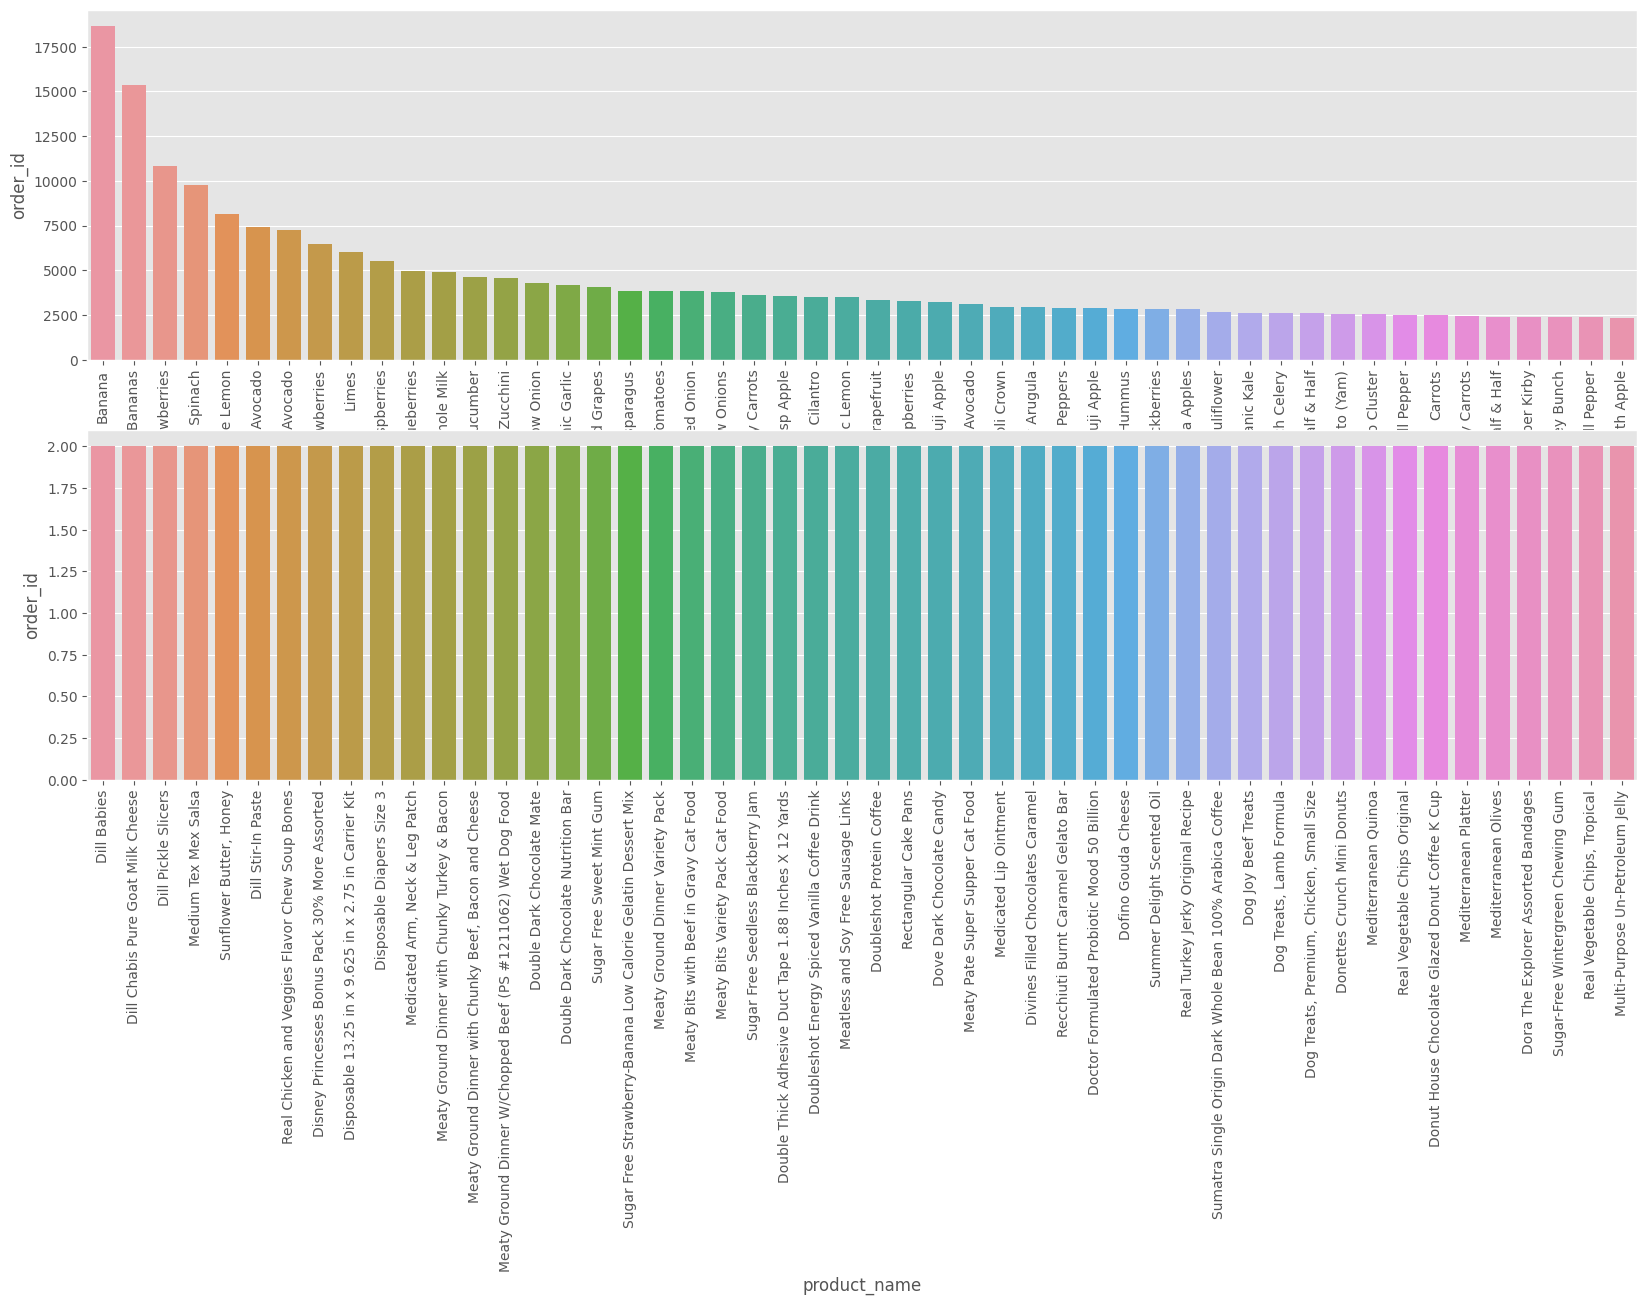

In [78]:
tmp = df.groupby('product_name')['order_id'].count().reset_index()

plt.figure(figsize=(20, 5))
ax = sns.barplot(data=tmp.sort_values(by='order_id', ascending=False).head(50), x='product_name', y='order_id')
ax.tick_params(axis='x', rotation=90)

In [79]:
df_txn = df.groupby('order_id')['product_name'].apply(set).reset_index()
df_txn

,order_id,product_name
0,1,"{Cucumber Kirby, Organic Whole String Cheese, ..."
1,36,"{Spring Water, Organic Garnet Sweet Potato (Ya..."
2,38,"{Flat Parsley, Bunch, Bunched Cilantro, Green ..."
3,96,"{Organic Cucumber, Organic Whole Strawberries,..."
4,98,"{Sliced Pepperoni, Plastic Spoons, Unsalted Cu..."
...,...,...
124355,3421049,"{Organic Baby Broccoli, Organic Baby Kale Mix,..."
124356,3421056,"{Sparkling Lemon Water, Total Plain Greek Stra..."
124357,3421058,{Wine Infused Salame Cheese and Crackers Small...
124358,3421063,"{Twice Baked Potatoes, Organic Half & Half, No..."


In [80]:
te = TransactionEncoder()
te_data = te.fit_transform(df_txn['product_name'].values, sparse=True)
df_te = pd.DataFrame.sparse.from_spmatrix(te_data, columns=te.columns_)
print(f'No. Transactions: {df_te.shape[0]:,.0f}')

No. Transactions: 124,360


In [81]:
support_dist = (df_te.sum(axis=0) / df_te.shape[0]).sort_values(ascending=False).rename('values').reset_index()
support_dist.describe(percentiles=[.25, .5, .75, .95, .99])

,values
count,31178.000000
mean,0.000353
std,0.001990
min,0.000016
25%,0.000024
50%,0.000064
75%,0.000201
95%,0.001246
99%,0.004650
max,0.149944


In [83]:
support_ranges_ = np.arange(0.0001, 0.0002, 0.00002)
confidence_ranges_ = np.arange(0.1, 0.7, 0.1)

report = pd.DataFrame(columns=['support_level', 'confidence_level', 'no_rules'])
for s in support_ranges_:
    for c in tqdm(confidence_ranges_, desc=f'Support Threshold: {s:,.5f}'):
        frequent_itemsets = fpgrowth(df_te, min_support=s, use_colnames=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=c)
        tmp = pd.DataFrame({'support_level': [f'support level: {s:,.5f}'], 'confidence_level': [c], 'no_rules': [rules.shape[0]]})
        report = pd.concat([report, tmp])

Support Threshold: 0.00018: 100%|█████████████████| 6/6 [02:55<00:00, 29.29s/it]


<AxesSubplot:xlabel='confidence_level', ylabel='no_rules'>

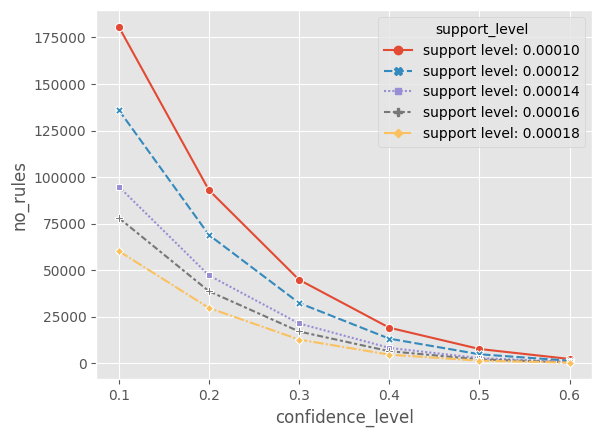

In [84]:
sns.lineplot(data=report.reset_index(drop=True), x='confidence_level', y='no_rules',
             hue='support_level', style='support_level', markers=True)

In [90]:
frequent_itemsets = fpgrowth(df_te, min_support=0.00018, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
print(f'No. Rules: {rules.shape[0]}')

No. Rules: 12809


In [91]:
for i in ['antecedents', 'consequents']:
    rules[f'combo_{i}'] = rules[i].map(lambda x: len(x))
    rules[i] = rules[i].map(lambda x: ' + '.join(tuple(x)))
rules['combo'] = rules['combo_antecedents'].astype(str) + ' - ' + rules['combo_consequents'].astype(str)
rules.drop(columns=['combo_antecedents', 'combo_consequents'], inplace=True)

In [92]:
rules['combo'].value_counts()

2 - 1    6911
3 - 1    5015
1 - 1     596
4 - 1     263
3 - 2      12
2 - 2      10
1 - 2       2
Name: combo, dtype: int64

In [93]:
rules.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,combo
11340,Sparkling Lemon Water + Pure Sparkling Water +...,Sparkling Water Grapefruit,0.000217,0.026890,0.000193,0.888889,33.056885,0.000187,8.757993,3 - 1
2433,Organic Lemon + Organic Hass Avocado + Organic...,Bag of Organic Bananas,0.000281,0.123633,0.000233,0.828571,6.701863,0.000198,5.112141,4 - 1
10288,Organic Navel Orange + Organic Lemon + Organic...,Bag of Organic Bananas,0.000394,0.123633,0.000322,0.816327,6.602821,0.000273,4.771331,3 - 1
1190,Organic Strawberries + Organic Grape Tomatoes ...,Bag of Organic Bananas,0.000281,0.123633,0.000225,0.800000,6.470764,0.000190,4.381835,4 - 1
11812,Cran Raspberry Sparkling Water + Sparkling Lem...,Sparkling Water Grapefruit,0.000241,0.026890,0.000193,0.800000,29.751196,0.000187,4.865552,3 - 1
...,...,...,...,...,...,...,...,...,...,...
8310,Original Pepperoni,Banana,0.000965,0.149944,0.000289,0.300000,2.000751,0.000145,1.214366,1 - 1
2583,Organic Hass Avocado + Organic Raspberries + F...,Organic Lemon,0.000643,0.028120,0.000193,0.300000,10.668573,0.000175,1.388400,3 - 1
1574,Organic Baby Spinach + Large Lemon + Organic Y...,Bag of Organic Bananas,0.000885,0.123633,0.000265,0.300000,2.426537,0.000156,1.251953,3 - 1
8287,Organic Zucchini + Organic Bosc Pear,Organic Strawberries,0.000643,0.087271,0.000193,0.300000,3.437575,0.000137,1.303899,2 - 1


<AxesSubplot:xlabel='confidence', ylabel='lift'>

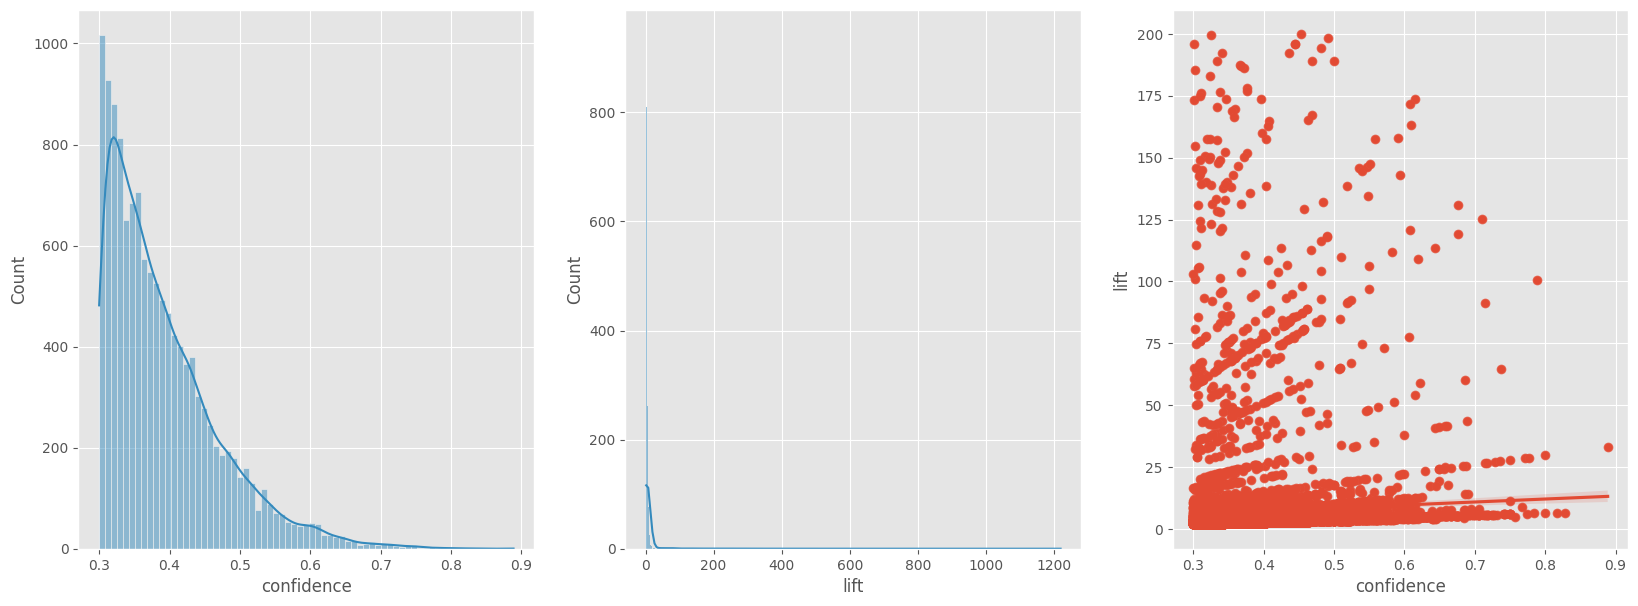

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes = axes.flatten()
sns.histplot(data=rules, x='confidence', kde=True, ax=axes[0])
sns.histplot(data=rules, x='lift', kde=True, ax=axes[1])
sns.scatterplot(data=rules.query('lift < 200'), x='confidence', y='lift', ax=axes[2])
sns.regplot(data=rules.query('lift < 200'), x='confidence', y='lift', ax=axes[2])